In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

## Data Loading

<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

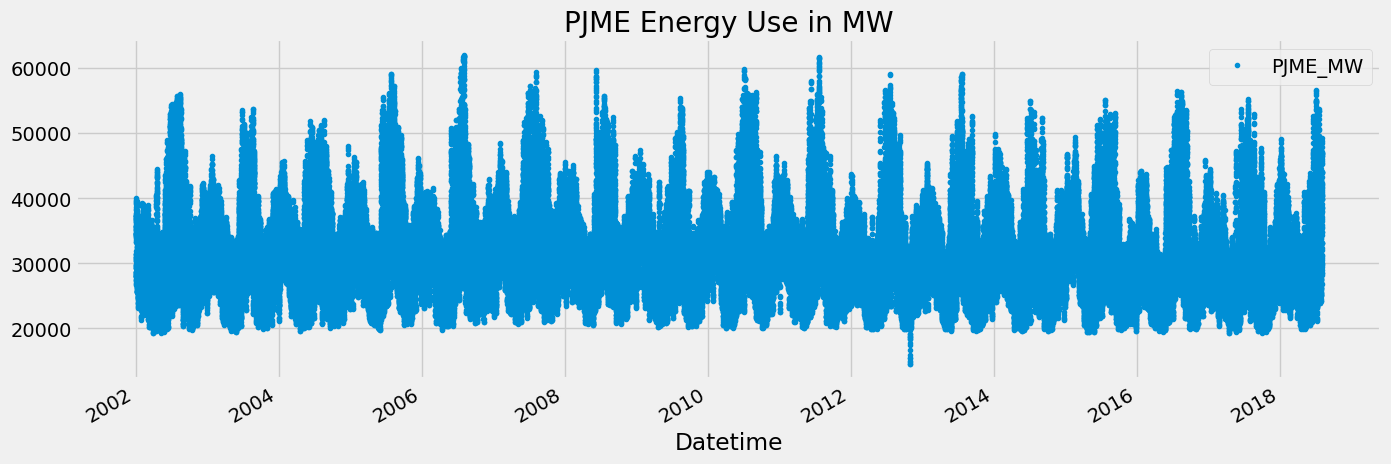

In [ ]:
data = pd.read_csv('PJME_hourly.csv')
data = data.set_index('Datetime')
data.index = pd.to_datetime(data.index)

data.plot(style = '.',
          figsize = (15, 5),
          color = color_pal[0],
          title = 'PJME Energy Use in MW')

## Data Splitting

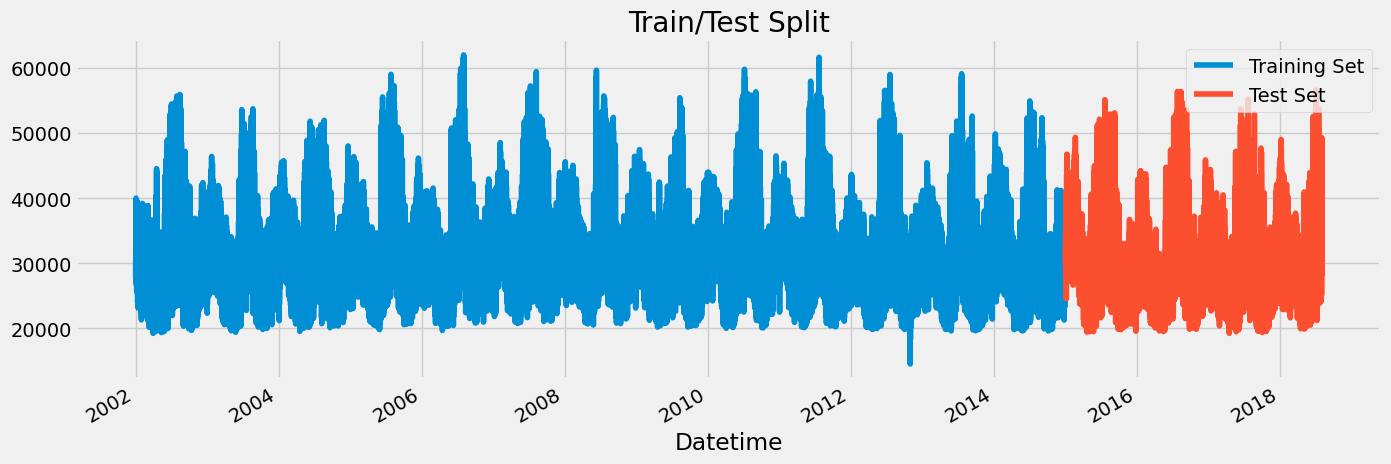

In [ ]:
trainData = data.loc[data.index < '01-01-2015']
testData = data.loc[data.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15, 5))
trainData.plot(ax = ax, label = 'Training Set', title = 'Train/Test Split')
testData.plot(ax = ax, label = 'Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Feature Creation

In [ ]:
def createFeatures(data):
  data = data.copy()
  data['hour'] = data.index.hour
  data['dayOfWeek'] = data.index.dayofweek
  data['quarter'] = data.index.quarter
  data['month'] = data.index.month
  data['year'] = data.index.year
  data['dayOfYear'] = data.index.dayofyear
  data['dayOfMonth'] = data.index.day
  data['weekOfYear'] = data.index.isocalendar().week

  return data

data = createFeatures(data)

## Data Visualization

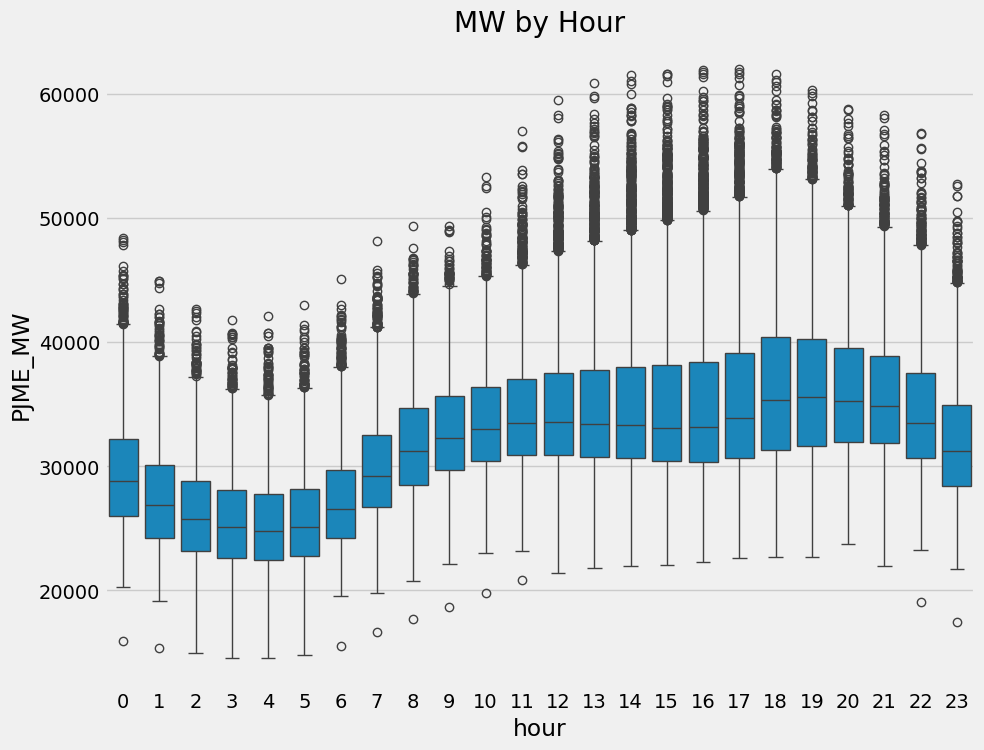

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = data, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

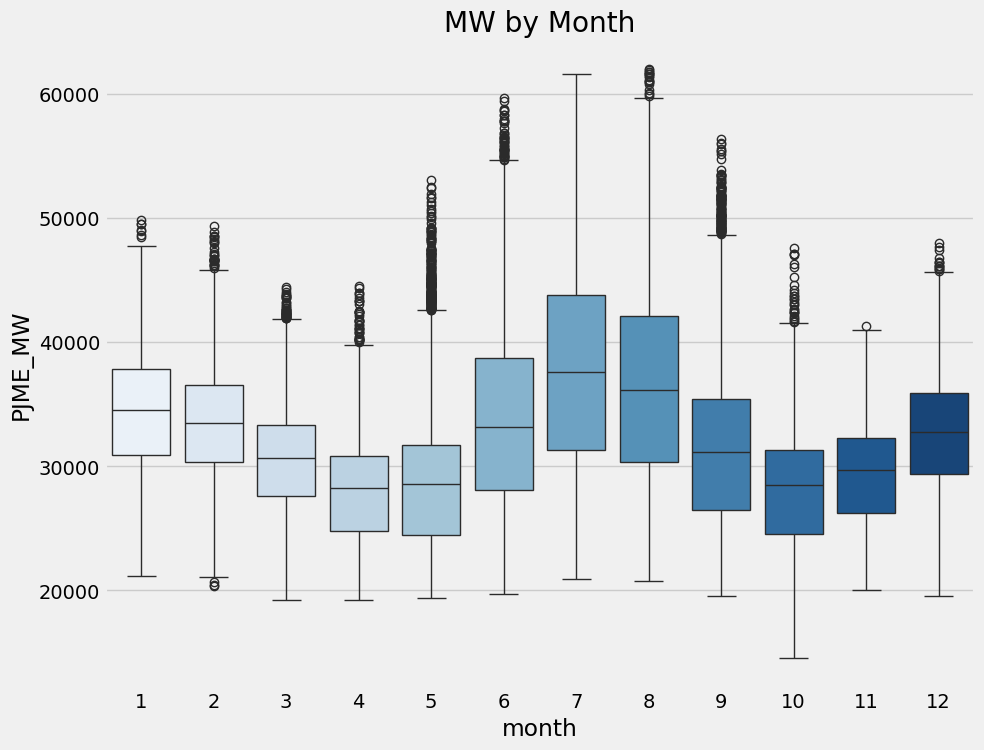

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = data, x = 'month', y = 'PJME_MW', palette = 'Blues')
ax.set_title('MW by Month')
plt.show()

## Model Training

In [ ]:
train = createFeatures(trainData)
test = createFeatures(testData)

FEATURES = ['dayOfYear', 'hour', 'dayOfWeek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                       n_estimators = 1000,
                       early_stopping_rounds = 50,
                       objective = 'reg:linear',
                       max_depth = 3,
                       learning_rate = 0.01)

reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

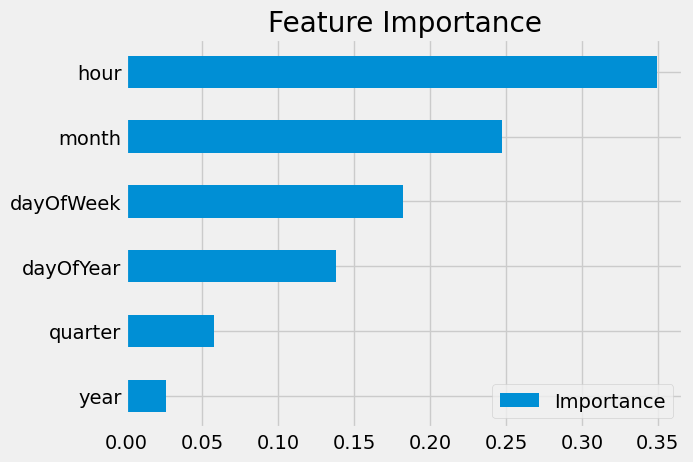

In [ ]:
featureImportance = pd.DataFrame(data = reg.feature_importances_,
                                 index = reg.feature_names_in_,
                                 columns= ['Importance'])
featureImportance.sort_values('Importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

## Forecast on Test

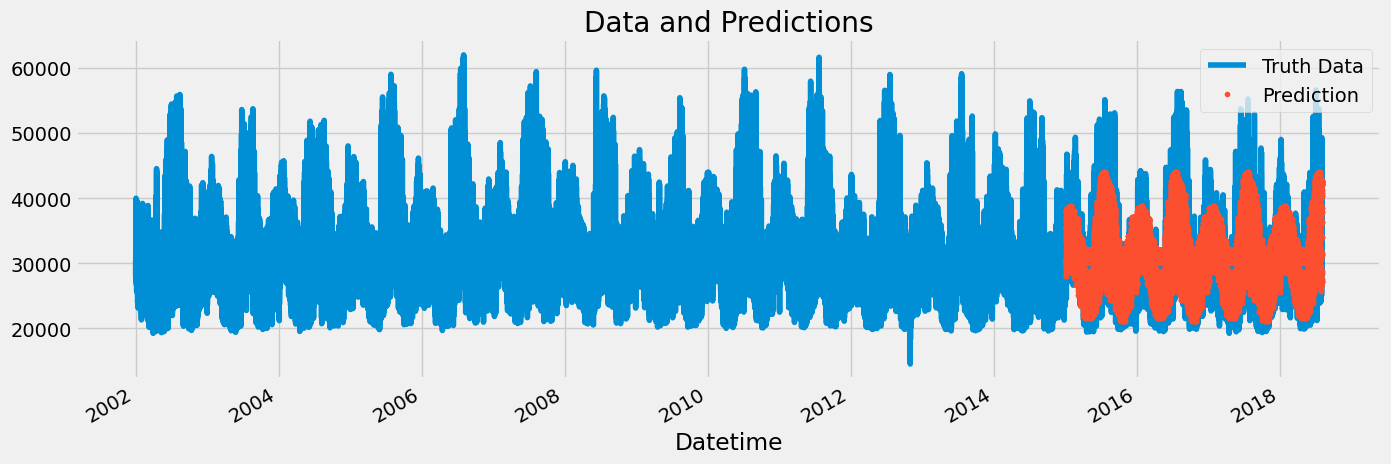

In [ ]:
test['Prediction'] = reg.predict(X_test)
data = data.merge(test[['Prediction']], how = 'left', left_index = True, right_index = True)
ax = data[['PJME_MW']].plot(figsize = (15, 5))
data['Prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Data and Predictions')
plt.show()

## Evaluation

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['Prediction']))
print(f'RMSE on Test Set: {score}')

RMSE on Test Set: 3726.7985806757774
